# A hands-on machine learning for astrophysics


In [10]:
!pip install numpy matplotlib seaborn pandas torch torchvision scikit-learn scikit-image skorch umap-learn h5py tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 7.4 MB/s eta 0:00:00


First, we'll import some libraries that will be useful for later.

In [2]:
# Graphs and figures
import matplotlib.pyplot as plt
import seaborn as sns

# Data/arrays manipulation
import numpy as np
np.random.seed(0) # for reproducibility
import pandas as pd

# Machine learning !
import sklearn

## Part 1: ML on tabular data: star type classification

We will start with a very common use case: tabular data. We assume that we have a set of observations (rows) and that for each one we have a set of measurements or *features* (columns). In this case, we will work with a star catalogue of 240 stars described by the following information:

- Temperature (in Kelvin)
- Luminosity (L/Lo)
- Radius (R/Ro)
- Absolute magnitude (Mv)

We also have the following data for each star:

- Color (Red/Orange/Yellow/White/Blue/…)
- Spectral class ('A', 'B', 'F', 'G', 'K', 'M', 'O')
- Star type (Brown dwarf/Red dwarf/White dwarf/Main sequence/Supergiant/Hypergiant)

This dataset has been collected by [Deepraj Baidya](https://github.com/deepraj1729) and was originally published on [Kaggle](https://www.kaggle.com/deepu1109/star-dataset). Measurements were collected either from Wikipedia or derived from the laws of physics.

### Objective

We want to build a decisional model to help us categorize stars based on their observed properties. Mathematically, this means that we want to build a classification function that outputs:

$f: (x_1, x_2, ..., x_n) \in \mathbb{R}^n \rightarrow f(x_1, ..., x_n) = y \in \{0, 1, 2, ..., k-1\}$, where:

* $(x_1, ..., x_n)$ represent the features (i.e. the observed physical properties),
* $y$ represents the index of the class (i.e. the star type).

This is a toy example but that will be helpful to demonstrate some core concepts from machine learning.

### Loading and preprocessing of the data

We can use the `pandas` library to read the `.csv` catalogue.

In [5]:
df_stars = pd.read_csv("/kaggle/input/star-new/stars.csv")

The dataset is comprised of 240 stars and their properties. Looking at the data, we can see that some of the variables are continuous values (e.g. temperature) while others are categorical (color and class).

In [6]:
df_stars

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,Brown Dwarf,Red,M
1,3042,0.000500,0.1542,16.60,Brown Dwarf,Red,M
2,2600,0.000300,0.1020,18.70,Brown Dwarf,Red,M
3,2800,0.000200,0.1600,16.65,Brown Dwarf,Red,M
4,1939,0.000138,0.1030,20.06,Brown Dwarf,Red,M
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Hypergiant,Blue,O
236,30839,834042.000000,1194.0000,-10.63,Hypergiant,Blue,O
237,8829,537493.000000,1423.0000,-10.73,Hypergiant,White,A
238,9235,404940.000000,1112.0000,-11.23,Hypergiant,White,A


Our goal with this dataset is try to learn a statistical that infers the star type based on its physical properties. There are 6 star types that are encoded in the *'Star type'* column. We call this information the **labels**.

The labels are currently encoded as strings which is practical for reading but not for computing. Using scikit-learn, we will convert this column into integers by assigning a unique int value to each star type. The `LabelEncoder` object is used to convert from a set of values to integers.

In [10]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Assign unique integers from 0 to 6 to each star type
df_stars['Star type'] = le.fit_transform(df_stars['Star type'])
class_names = le.classes_
print(class_names)

[0 1 2 3 4 5]


In [13]:
labels = le.inverse_transform(df_stars['Star type'])

We want to build a statistical model that learns how to map Temperature/Luminosity/Radius/Absolute magnitude to the star type. Since the labels are categorical, this task is called **classification**.

We will use a supervised approach: we build a model by training it on some examples for which we know the actual labels (the *ground truth*). Then, we will try to see if the model can infer the right star type on new data that it has not seen during training.

### Preliminary analysis

It is often grood practice to start with a statistical analysis of the dataset to answer the following questions:
* are there any missing values?
* are there NaNs in the data?
* are some variables redundant (i.e. strongly correlated)?
* is the data distribution skewed somehow?

We can start by plotting the correlations between variables:

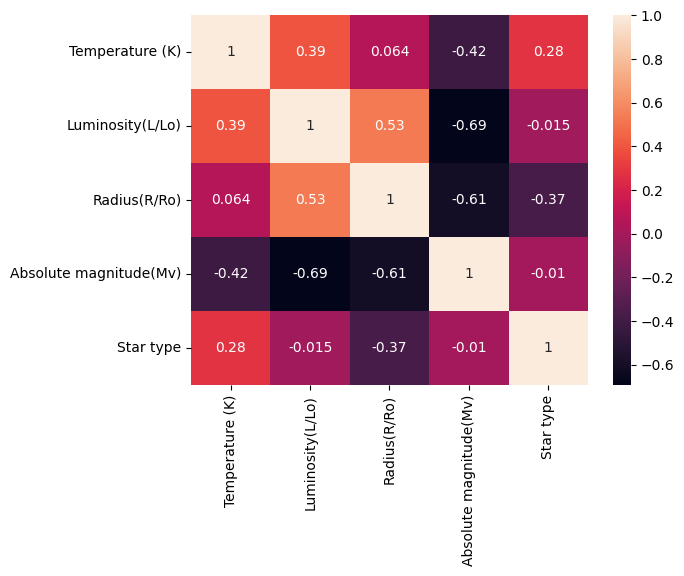

In [17]:
## Correlation between variables
sns.heatmap(df_stars.drop(['Star color','Spectral Class'],axis=1).corr(), annot=True) and plt.show()

The star type is not correlated with any particular column from the catalogue. We can see that some variables are correlated (either positively or negatively) but not entirely redundant. If two variables were too strongly correlated, it might have been a good idea to remove one of the two.

Star classification is something that can be done based on rules depending on temperature and luminosity. For example, Wikipedia gives the following example of a Hertzsprung-Russell diagram:
![](https://upload.wikimedia.org/wikipedia/commons/6/6b/HRDiagram.png)

We can reproduce this diagram by plotting the scatter plot of our stars using the same variables in log-log-scale.

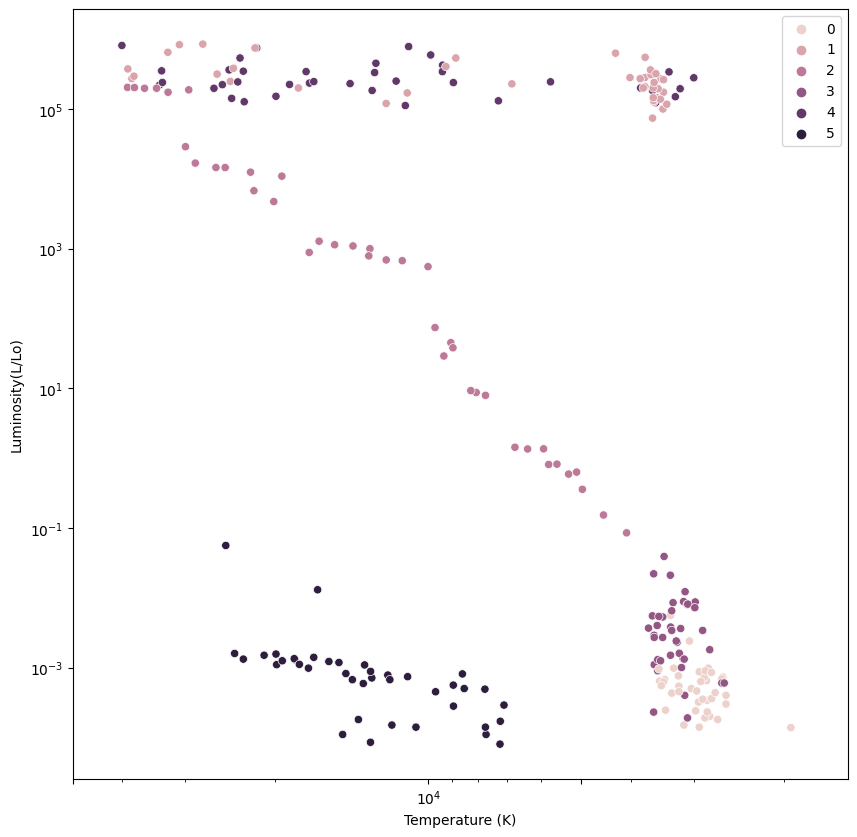

In [18]:
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_stars, x='Temperature (K)', y='Luminosity(L/Lo)', hue=labels)
plt.xscale('log')
plt.yscale('log')
plt.xticks([5000, 10000, 50000])
plt.xlim(5e4, 1.5e3)
plt.show()

We find the same organization of stars in this 2D plane. Main Sequence stars and White Dwarves are fairly easy to isolate from the rest: a statistical model should be able to easily classify them. Based only on Luminosity and Temperature, Dwarf stars and Giant stars have higher intra-group variability: Supergiant and Hypergiant cover the same space (same for Brown and Red Dwarves). Additionnal variables might be needed to correctly identify the types of those stars.

### Dimension reduction

A first common step for data analysis is dimension reduction to reduce the number of features (column variables) in the dataset. There are two main uses for dimension reduction algorithms:

1. visualization by reducing the number of variables to 2 or 3
2. reducing the number of variables for easier data mining (e.g. fighting the curse of dimensionality)

A well-known dimension reduction algorithm is the **Principal Component Analysis** (PCA). PCA finds linear combinations of variables that explain most of the variance in the data.

`scikit-learn` offers a PCA module that is straightforward to use. Nearly all statistical models implemented in `sklearn` follow the same interface. Let's start by importing the module.

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

By default, the ``PCA()`` object performs a full decomposition with as many components as there are input variables. However in this case we will perform a PCA for visualization using a 2D point cloud, so we can keep only the first 2 principal components.

Performing the actual PCA is done using the ``.fit()`` method on the data. We will keep only the physical measurements for this analysis. PCA is **unsupervised**, which means the model depends only the observations (and it does not require labels).

In [20]:
df_stars_data = df_stars.drop(columns=["Star color", "Star type", "Spectral Class"])
X = np.array(df_stars_data)

Note that scikit-learn expects a ``NumPy`` array. It will automatically convert the data that is fed into it into ``np.array`` if needed. In our case, the pandas table are converted on the fly. We won't do it manually in the rest of this notebook.

`X` now represents our data matrix on which we will be able to perform machine learning.

Let's apply a PCA on the dataset. PCA will project our data in a 2-dimensional space that maximizes variance:

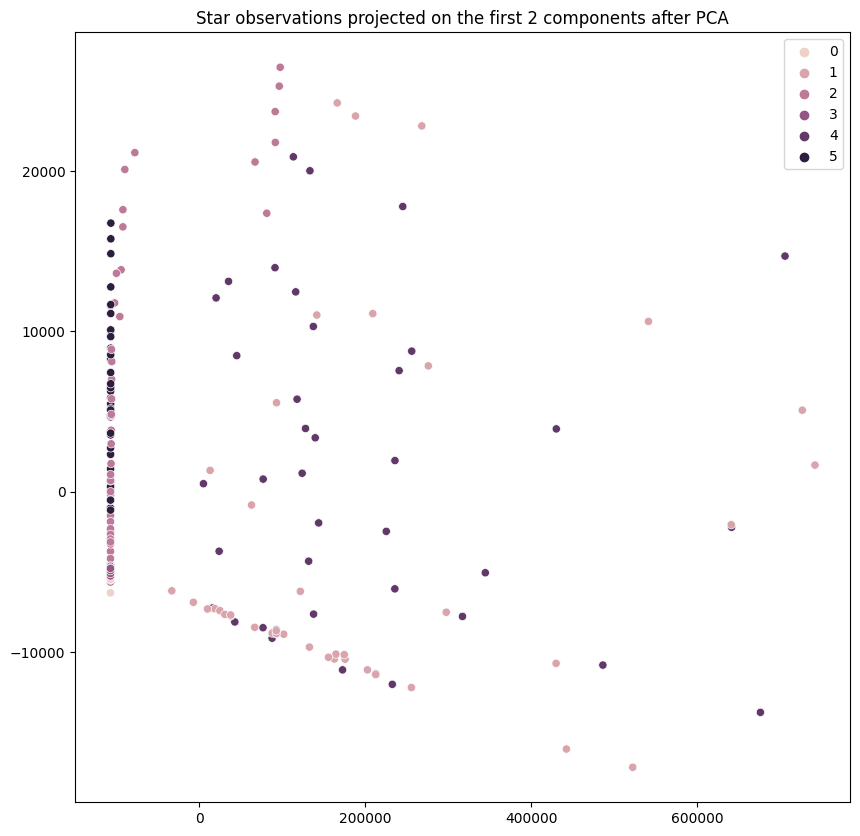

In [21]:
projected_stars = pca.fit_transform(X)

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x=projected_stars[:,0], y=projected_stars[:,1], hue=labels)
plt.title("Star observations projected on the first 2 components after PCA")
plt.show()

Are we happy? Well, not so much: many stars are projected at the same x-axis coordinate and the remaining stars are not easy to separate in the 2D plane. However, we forgot something: **standardization**! Our various columns are expressed in different units which artifically distorts the amplitude of the numerical values. Let's use scikit-learn built-in scaler to center (mean=0) and normalize (std=1) the data.

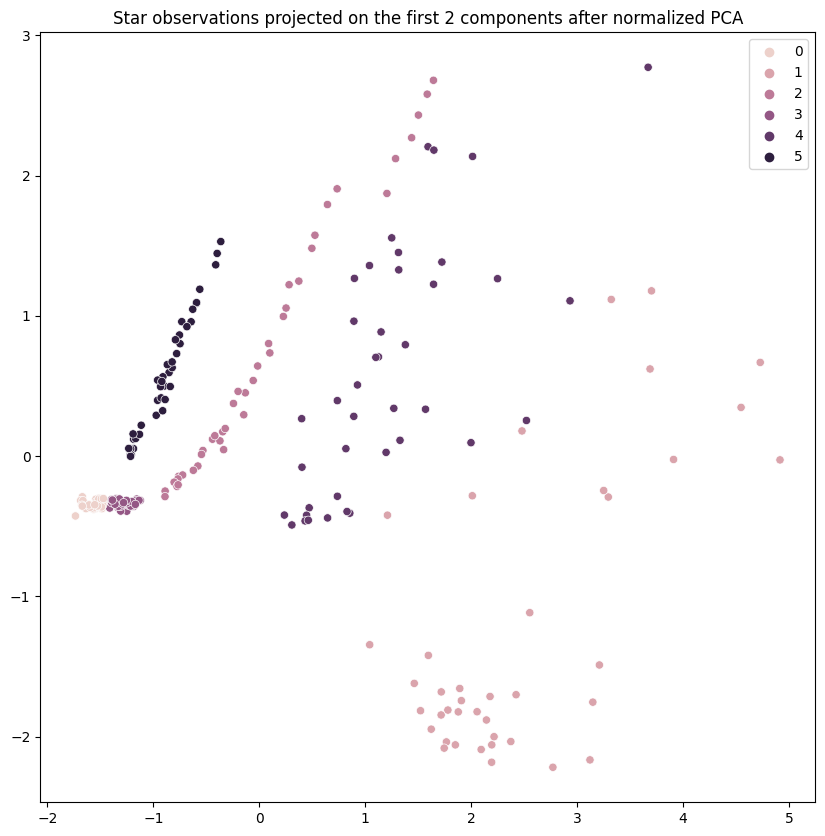

In [22]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df_stars_data)

pca = PCA()
projected_stars = pca.fit_transform(X)

fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x=projected_stars[:,0], y=projected_stars[:,1], hue=labels)
plt.title("Star observations projected on the first 2 components after normalized PCA")
plt.show()

This is a lot better! In this point cloud, we can actually see some clusters emerge: stars of the same type tend to be projected around the same point in the 2D plane. This is encouraging since it means that our observations look like they are linearly separable (i.e. we can draw a line that separates each star type from all the others).

**Take away 1**: when dealing with a new dataset, data normalization or standardization often makes data mining easier. For linear models, rescaling is required when dealing with values expressed in different units.

PCA finds the linear combinations that explain most of the variance. We can check how much information we lost by keeping the first two components using the `explained_variance_ratio_` attribute:

In [23]:
s = 0
for idx, r in enumerate(pca.explained_variance_ratio_):
    s += r
    print(f"Component {idx+1} explains {100*r:.1f}% of the variance (cumulative = {100*s:.1f})")

Component 1 explains 60.4% of the variance (cumulative = 60.4)
Component 2 explains 23.5% of the variance (cumulative = 83.9)
Component 3 explains 9.3% of the variance (cumulative = 93.2)
Component 4 explains 6.8% of the variance (cumulative = 100.0)


Therefore the projection on the 2D plane explains 84% of the variance of the dataset. The visualization does not hide too much information so it gives a pretty faithul depiction of the dataset.

### Model selection : train/test split and cross-validation

After this preliminary analysis, we decide to keep all four features (temperature, magnitude, radius and luminosity). We will build a statistical model that infers the star type based on these values.

To evaluate how accurate our model will be, we split the dataset into two parts: the training set and the test set.

The training set is used to fit the statistical model. These are the examples that are used to "train" the model. We expect that the model will be very accurate on these data. But 100% accuracy on the training set is not necessarily a sign that the model is useful: memorization (or *overfitting*) can happen!

Therefore, we will evaluate the accuracy on the held-out test set. The samples from the test set were not seen during the training of the model. It will therefore measure how well the model **generalizes** to new data.

scikit-learn makes it very easy to divide a dataset into train and test, for example using the `train_test_split` function. For our example, let's use only 20% of the dataset as training samples.

In [24]:
from sklearn.model_selection import train_test_split
stars_train, stars_test = train_test_split(df_stars.drop(columns=["Star color", "Spectral Class"]), train_size=0.2)

We can now build four arrays: `X_*` will be the features (our input) and `y_*` will be our targets (the star types we want to predict).

In [25]:
X_train, y_train = stars_train.drop(columns="Star type"), stars_train["Star type"]
X_test, y_test = stars_test.drop(columns="Star type"), stars_test["Star type"]

### Decision tree

Decision trees are very common in machine learning. Their strong suit is their interpetability: it is easy to understand a posteriori why the model predicted type A instead of type B. Decision trees are implemented in `sklearn` in the `tree` module.

In [26]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()

As before, we will use the `.fit()` method to train the statistical model. However, since decision trees are **supervised** models, we need not only to pass the data `X` as an argument, but also the **labels** `y`.

As you can see, we fit (*learn*) the model on the training pairs (data `X_train` and targets `y_train`).

In [27]:
tree.fit(X_train, y_train)

DecisionTreeClassifier()

Done! We now have a decision tree. But is it any good? One way to evaluate our model is check its *accuracy* on our held-out test data. Accuracy is defined as `1 - #errors`. We can use the ``.predict()`` method to perform inference on an arbitrary sample.

In [28]:
tree.predict(X_test)

array([4, 3, 2, 3, 4, 4, 2, 4, 2, 3, 0, 5, 5, 2, 1, 3, 3, 1, 4, 0, 2, 1,
       5, 3, 0, 5, 3, 2, 3, 4, 1, 4, 5, 3, 5, 1, 5, 1, 0, 3, 2, 4, 2, 3,
       4, 3, 2, 0, 1, 1, 0, 2, 1, 3, 2, 2, 1, 2, 1, 4, 3, 2, 2, 1, 5, 2,
       0, 2, 0, 3, 0, 4, 3, 2, 1, 3, 5, 1, 4, 2, 4, 3, 0, 4, 5, 2, 2, 3,
       1, 3, 3, 3, 1, 4, 1, 3, 5, 1, 1, 0, 3, 5, 0, 3, 4, 3, 4, 0, 5, 1,
       2, 5, 2, 4, 0, 1, 3, 5, 3, 5, 0, 1, 5, 4, 3, 3, 3, 3, 3, 1, 1, 2,
       2, 2, 4, 4, 1, 3, 2, 2, 0, 4, 4, 5, 1, 5, 5, 5, 0, 2, 3, 5, 1, 0,
       0, 5, 3, 4, 0, 5, 3, 3, 3, 5, 3, 1, 4, 2, 1, 3, 3, 3, 3, 4, 4, 3,
       5, 3, 2, 3, 1, 4, 3, 0, 2, 5, 3, 1, 4, 2, 2, 3])

We could loop on all test samples and check whether the prediction matches the expected label. However, ``sklearn`` implements the convenient ``.score()`` function to do so, so let's use it:

In [29]:
tree.score(X_test, y_test)

0.8489583333333334

Great! Our model reaches over 84% accuracy on the test set. Well, the dataset is fairly easy. :-)

Knowing how many stars have been accurately classified is good but for a more detailed analysis, we can turn to the confusion matrix. The confusion matrix indicates for each actual star type (rows) how the stars of this group have been predicted (columns).

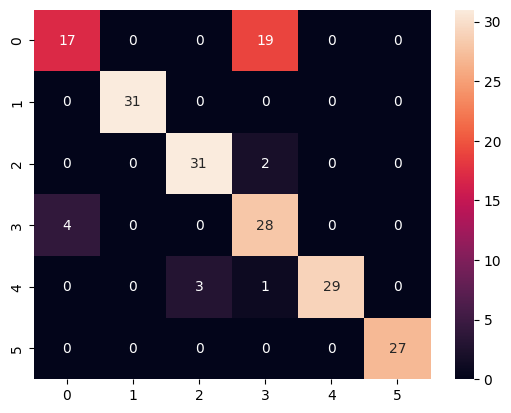

In [30]:
from sklearn.metrics import confusion_matrix

y_pred = tree.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, xticklabels=class_names, yticklabels=class_names)
plt.show()

We can now see that the 35 brown dwarves of the test dataset have all been correctly predicted as brown dwarves. However, 8 stars from the Main Sequence have been classified as Red Dwarfs.

As said before, one big advantage of decision trees is that they are easy to interpret. For example, you can draw the full decision tree to understand the different tests that are made before taking the final decision:

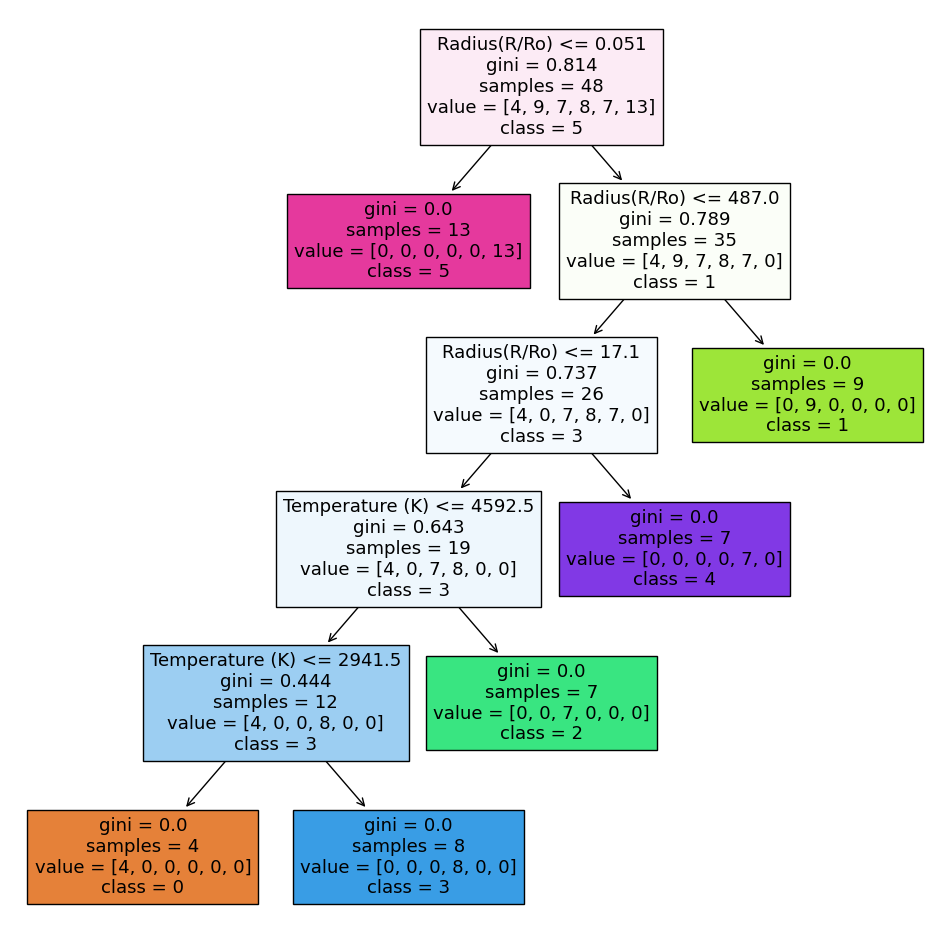

In [32]:
fig = plt.figure(figsize=(12, 12))
sklearn.tree.plot_tree(tree, filled=True, feature_names=stars_train.drop(columns="Star type").keys(), class_names=[str(i) for i in class_names])
plt.show()


### SVM

Now, decision trees are nice but they are fairly simple models. In the shallow ML world, Support Vector Machines (SVM) are all the rage. But do I have to rewrite all my code to use them? Nope! All models in scikit-learn have the same interface so you can just swap your ``DecisionTree`` with a ``SVC`` (Support Vector Classifier).

Check this out:

In [33]:
from sklearn.svm import SVC
scaler2 = StandardScaler()
X_train_s = scaler2.fit_transform(X_train)
X_test_s = scaler2.transform(X_test)
svm = SVC()
svm.fit(X_train_s, y_train)
svm.score(X_test_s, y_test)

0.765625

Great. However there is one little problem: the SVM is underperforming very badly the decision tree. Why? We let ``sklearn`` use the default parameters in the ``SVC()``. There are various parameters that you can use in an SVM. The two main ones are:

- the kernel (by default, scikit-learn uses a linear SVM, fast but not great. We often use a RBF kernel, slower but more powerful.)
- the regularization parameter ``C`` (it controls how "smooth" the decision border is).

So for example, I can ask for an SVM with a polynomial kernel of degree 4 and ``C=100`` using:

In [34]:
svm = SVC(C=100, kernel='poly', degree=4)
svm.fit(X_train_s, y_train)
svm.score(X_test_s, y_test)

0.9375

Much better. But you probably don't want to manually try all those values. Plus, if you try dozens of combinations and you check the score every time on the set, you are manually overfitting the test set. The hyperparameters that you find will be the best for your test set but many not the best for your future observations.

So the idea is to automatically explore several hyperparameters combinations (for example using a *grid search*). To avoid overfitting the test set, we will do cross-validation for each combination. scikit-learn conveniently offers a tool called ``GridSearchCV`` to this end and its interface is the same as all the other models!

In [35]:
from sklearn.model_selection import GridSearchCV

grid = {'C': [1e-2, 0.1, 1.0, 10, 100, 1000, 10000], 'kernel': ['linear', 'rbf'], 'gamma': ['auto', 'scale']}
model = GridSearchCV(SVC(), grid)
model.fit(X_train_s, y_train)
model.score(X_test_s, y_test)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


1.0

Yay! We found an SVM that performs the same as our decision tree. We can print out its hyperparameters it we want to reuse them later.

In [36]:
model.best_params_

{'C': 10, 'gamma': 'auto', 'kernel': 'linear'}

## Part 2: ML on image data

Let's move on to a harder problem. We have seen how to perform machine learning on tabular data, i.e. 1-dimensional data. Tabular data is often structured, meaning that the columns are known to be significant in a way or the other. The raw information has already been processed and synthesized in a catalogue.

But what if we want to go back the source? Computer vision provides a diverse set of tools taken from both image processing and machine learning that can help to perform data mining in large collections of image.

In [1]:
import urllib.request
urllib.request.urlretrieve("http://astro.utoronto.ca/~bovy/Galaxy10/Galaxy10.h5", "Galaxy10.h5")

('Galaxy10.h5', <http.client.HTTPMessage at 0x7b6248186680>)

The dataset that we downloaded comes from the [`astroNN` package](https://astronn.readthedocs.io/en/latest/galaxy10.html). It is based on the [Galaxy Zoo collection](https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/) which itself uses images from the Sloan Digital Sky Survey (SDSS). Let's check out what the images look like.

In [2]:
import numpy as np
import h5py

# Images and labels are stored in HDF5 format but we could use flat files instead
with h5py.File('Galaxy10.h5', 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'], dtype='int64')

print(f"Galaxy10 dataset: {len(images)} images and {len(np.unique(labels))} classes")

Galaxy10 dataset: 21785 images and 10 classes


We are dealing with 69x69 color images of galaxies. The goal of the Galaxy10 dataset is perform classification of these images into one of the 10 galaxy shapes defined hereafter:

In [3]:
class_names = [
    "Disk, Face-on, No Spiral",
    "Smooth, Completely round",
    "Smooth, in-between round",
    "Smooth, Cigar shaped",
    "Disk, Edge-on, Rounded Bulge",
    "Disk, Edge-on, Boxy Bulge",
    "Disk, Edge-on, No Bulge",
    "Disk, Face-on, Tight Spiral",
    "Disk, Face-on, Medium Spiral",
    "Disk, Face-on, Loose Spiral"
]

We can display using Matplotlib one example of each class:

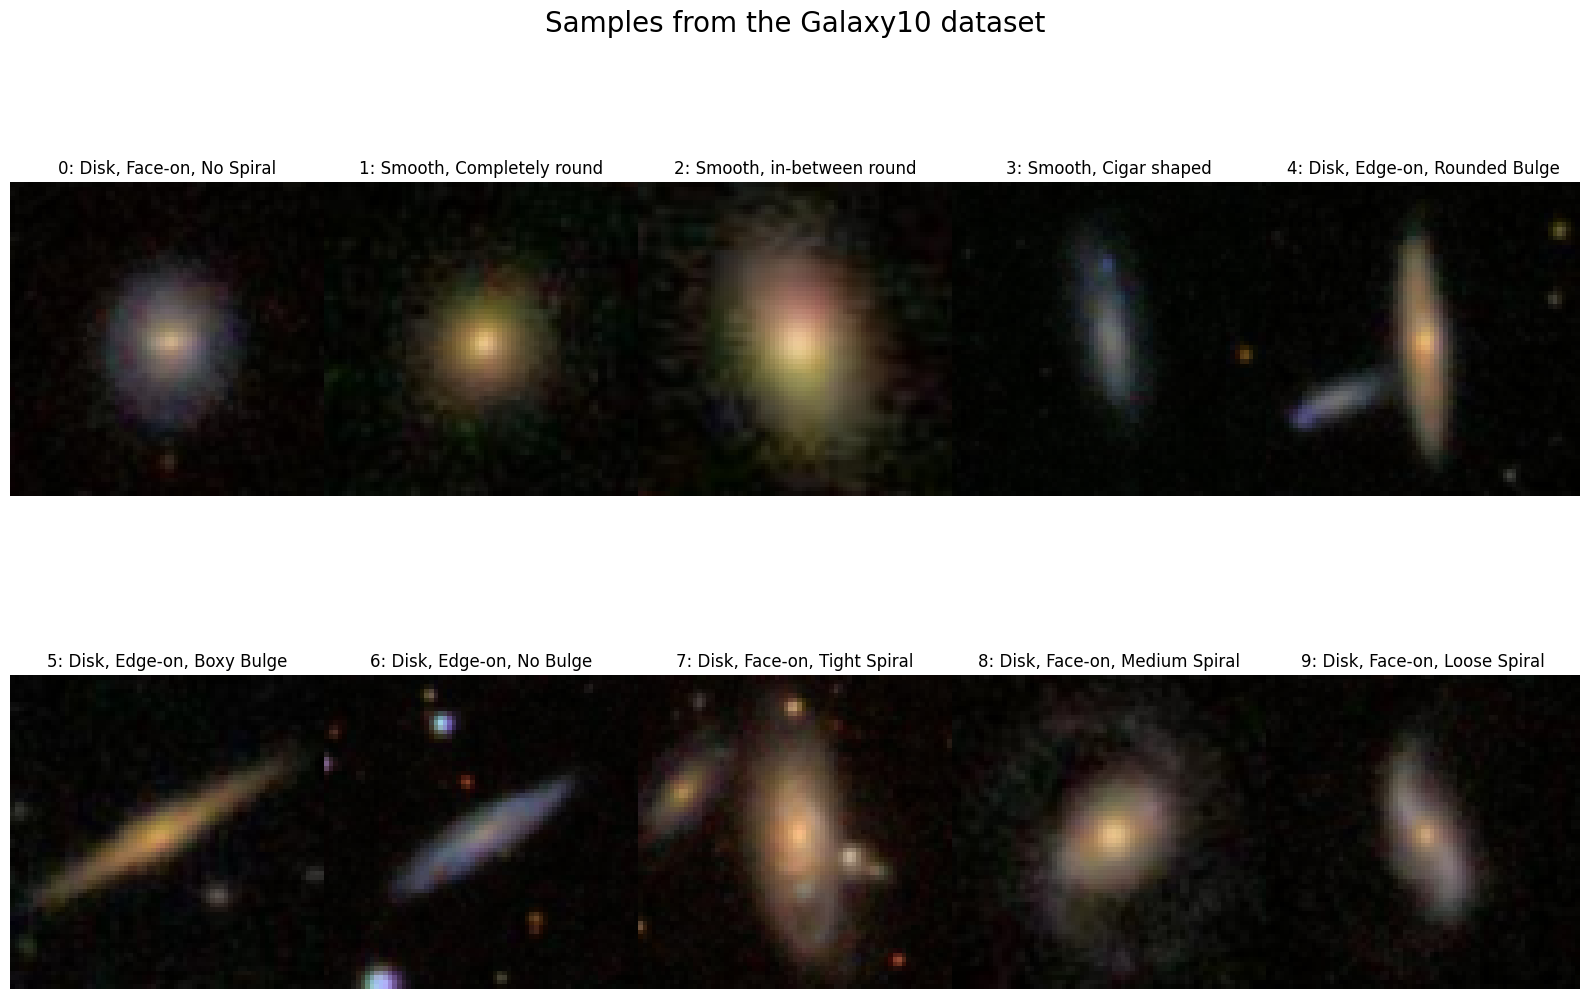

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

_, demo_idx = np.unique(labels, return_index=True)

fig = plt.figure(figsize=(16, 12))
for idx, (img, label) in enumerate(zip(images[demo_idx], labels[demo_idx])):
    fig.add_subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{label}: {class_names[label]}")
fig.tight_layout(h_pad=0, w_pad=0)
plt.suptitle("Samples from the Galaxy10 dataset", fontsize=20)
plt.show()

As usual, we will split the dataset in two. In this case, we will use 60% of the images for training and the remaining 40% for test.

In [5]:
from sklearn.model_selection import train_test_split
images_train, images_test, y_train, y_test = train_test_split(images.astype('float32'), labels, train_size=0.6)

### Standard image features

When working with images, the standard approach for object recognition was to use so-called feature descriptors. These descriptors are a way to describe some properties of the image in a compressed vector with a smaller dimension than the full image matrix. Examples of such descriptors are the [wavelet decomposition](https://en.wikipedia.org/wiki/Discrete_wavelet_transform#Example_in_image_processing) or [color histograms](https://en.wikipedia.org/wiki/Color_histogram).

These descriptors are then used instead of the image as features for ML models. This section illustrates how to apply this pipeline on the Galaxy10 dataset.


#### HOG + SVM

Histogram of Oriented Gradients (HOG) is a classical feature descriptor for images. It is very popular in computer vision for object detection and classification. The core idea is that the image will be divided in blocks. On each block, gradients will be computed for different orientations.

The HOG algorithm was introduced by [Navneet Dalal and Bill Triggs in 2005 for pedestrian detection](https://hal.inria.fr/inria-00548512/document).

The `scikit-image` library has built-in support for HOG. A common pipeline for image classification is the so-called HOG+SVM pipeline. It is comprised of two steps:
1. extract HOG from all images (this produces a 1D feature vector for all images)
2. train a SVM on the HOG features

In [6]:
from skimage.feature import hog
from tqdm.notebook import tqdm

def hog_galaxy10(image):
    # Compute the Histogram of Oriented Gradients on an image
    # We use 8 orientations and 8 pixels in a cell/block
    if image.ndim == 2:
        return hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1,1))
    elif image.ndim == 3:
        return hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1,1), channel_axis=-1)
    else:
        raise ValueError("Unsupported image dimension: {}".format(image.ndim))

# Extract HOG on the training and testing images.
# This will take a few seconds.
X_train = np.array([hog_galaxy10(image) for image in tqdm(images_train, desc="HOG on train")], dtype='float32')
X_test = np.array([hog_galaxy10(image) for image in tqdm(images_test, desc="HOG on test")], dtype='float32')


HOG on train:   0%|          | 0/13071 [00:00<?, ?it/s]

HOG on test:   0%|          | 0/8714 [00:00<?, ?it/s]

As an example, we can produce a 2D visualization of what the HOG "sees" in the image.

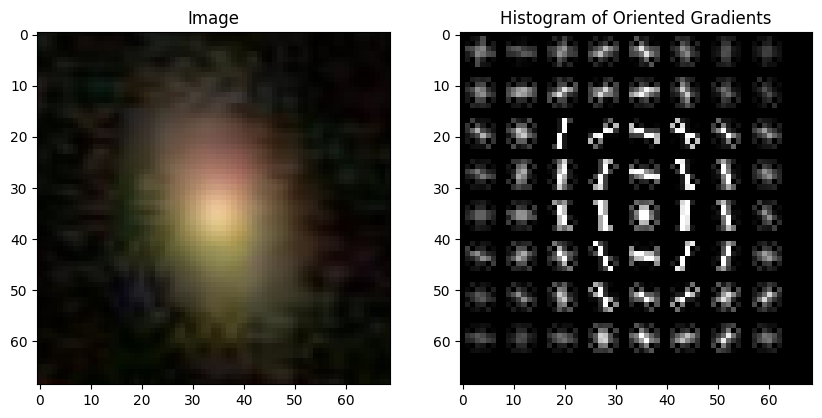

In [7]:
from skimage import data, exposure

# Check if the image has multiple channels
multichannel = len(images[0].shape) == 3

# Compute HOG features
if multichannel:
    feat, hog_image = hog(images[0], orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1,1), visualize=True, channel_axis=-1)
else:
    feat, hog_image = hog(images[0], orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1,1), visualize=True)

# Plot the images
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(121)
plt.imshow(images[0], cmap='gray' if not multichannel else None)
plt.title("Image")
fig.add_subplot(122)
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
plt.imshow(hog_image, cmap='gray')
plt.title("Histogram of Oriented Gradients")
plt.show()


In [8]:
from sklearn.svm import LinearSVC

svm = LinearSVC(max_iter=2000)
svm.fit(X_train, y_train)
svm.score(X_test, y_test)

0.6013311911865963

#### HOG + Neural networks

Some neural networks can be used as drop-in replacements for traditional ML models. Actually, simple neural networks have been used since the 60s. Although `sklearn` implements some basic neural networks (called the Multilayer Perceptron or MLP), we are not going to use it since it does not support GPU acceleration. Instead, we are going to use the PyTorch tensor computing library.

In their core, PyTorch and Tensorflow are generic tensor computing libraries (similar to NumPy) that support GPU acceleration for faster computing. However, those libraries have been designed with deep learning in mind which means that they also support automatic differentiation (required to train neural networks using backpropagation) and expose useful functions to define neural networks.

We will start by importing the torch library and the skorch wrapper. As we will see, `skorch` is wrapper around torch that transforms neural networks defined with torch into Python objects that follow the same interface as scikit-learn models. This makes it very easy to work move from shallow ML to deep learning.

In [11]:
import torch
import skorch
# For reproducibility purposes, we set the random number generator seed manually.
torch.manual_seed(0)

Neural networks can be computationally expensive. To reduce the compute time, we can use accelerators such as Graphical Processing Units (GPU). Originally designed for 3D rendering and gaming, GPUs are very effective for parallel matrix multiplication.

The next code cell checks if an NVIDIA GPU supporting CUDA acceleration is available. If not, the torch code will execute on CPU (and it will be around 10x slower).

In [12]:
# Check if GPU is available, fallback on CPU if not
device = 'cuda' if torch.cuda.is_available else 'cpu'

Let's define a simple neural network. Building neural networks can sometimes look like LEGO, where you stack layers of predefined functions.

The most basic layer is the `Linear` (or *fully connected* layer). It takes as an input a vector $X \in \mathbb{R}^p$ and produces a vector $Z \in \mathbb{R}^q$. Fundamentally, this is a matrix multiplication :
$Z = W.X + b$

All neurons (values) from $X$ are connected to every neuron of $Z$. The weights $w_{i,j}$ of the matrix $W$ define the weight of the $p \times q$ synaptic connections. $b$ is a constant bias vector $\in \mathbb{R}^q$.

**Caveat**: $W$ can become very large (more than 1 million parameters) when $p$ and $q$ grow.

The `Linear` layer is actually the most basic neural network than you can imagine. In the 60s, it was called the  [Perceptron](https://en.wikipedia.org/wiki/Perceptron). In the Perceptrons book (1969), Marvin Minsky and Seymour Papert noted that, because the relation between $Z$ and $X$ is linear, the Perceptron has a very limited capacity (for example a Perceptron cannot approximate the XOR function).

But what if we added more layers? Well, $Z = W_1 . W_2 . W_3 . X$ is still a single linear matrix multiplication. The trick is to add **non-linearities** between the layers.

Vaguely similar to what happens in biological neurons, we will now say that the output of a neuron is the sum of its weighted inputs **passed through an non-linear activation function**. Any differentiable non-linear function will do but most often, we use the ReLU activation from [Glorot et al., 2011](http://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf).

$$ReLU: x \rightarrow max(0, x)$$

We can now define a non-linear MultiLayer Perceptron (MLP). There are multiple ways to define a neural network in PyTorch. For simple models, the fastest approach is to use the `Sequential` API.

In [13]:
from torch import nn

mlp = nn.Sequential(
    nn.Linear(512, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10)
)

`mlp` now defines a `torch` neural network object. Using `skorch`, we will define an estimator similar to the previous objets we used in scikit-learn:

In [14]:
nn_classifier = skorch.classifier.NeuralNetClassifier(mlp,
                                                      lr=0.05, # Learning rate
                                                      max_epochs=50, # Number of epochs
                                                      criterion=nn.CrossEntropyLoss, # Loss function
                                                      device=device) # Execute on GPU or CPU

We give to `skorch` some hyperparameters, namely:
- the loss function that we want to minimize. In our case, we use the cross entropy loss which is the most common for classification.
- the learning rate, which defines the amplitude of the step in the gradient descent training algorithm.
- the `max_epochs` parameters which defines how long the network will be trained. With `max_epochs=20`, the model will see every sample in the training dataset 20 times.

Now that we defined our neural network using `skorch`, we can use the `fit` and `score` methods as before.

In [15]:
nn_classifier.fit(X_train, y_train)
nn_classifier.score(X_test, y_test)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.8455       0.3277        1.7319  0.6219
      2        1.7174       0.3277        1.6997  0.2932
      3        1.6708       0.3277        1.6321  0.3113
      4        1.5861       0.3614        1.5421  0.2947
      5        1.5130       0.3809        1.4675  0.2862
      6        1.4921       0.3904        1.4272  0.2917
      7        1.4712       0.3985        1.4029  0.2889
      8        1.4522       0.4195        1.3757  0.2932
      9        1.4343       0.4505        1.3473  0.2897
     10        1.4157       0.4860        1.3202  0.2951
     11        1.3956       0.5098        1.2938  0.2965
     12        1.3738       0.5270        1.2679  0.2951
     13        1.3509       0.5434        1.2416  0.2972
     14        1.3268       0.5514        1.2157  0.2925
     15        1.3008       0.5610        1.1909  0.2929
     16        1.2724       0.5

0.6908423226991048

Done! We now have trained our first neural network. At first glance, it performs significantly better on the HOG features than the SVM baseline (but remember that we did not fine-tune the SVM hyperparameters so it is a pessimistic baseline).

**Takeaway 4**: `skorch` allows you to use deep neural networks in the same way as scikit-learn models.

We can plot both confusion matrices to compare the models.

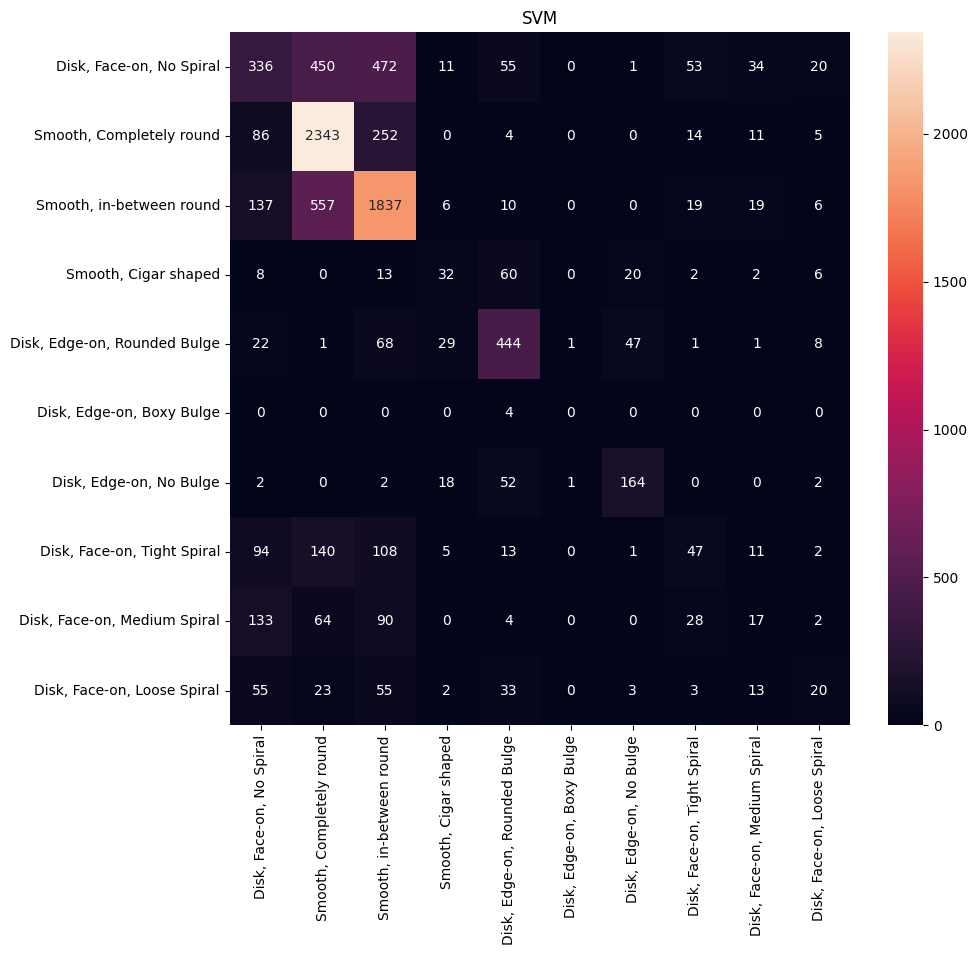

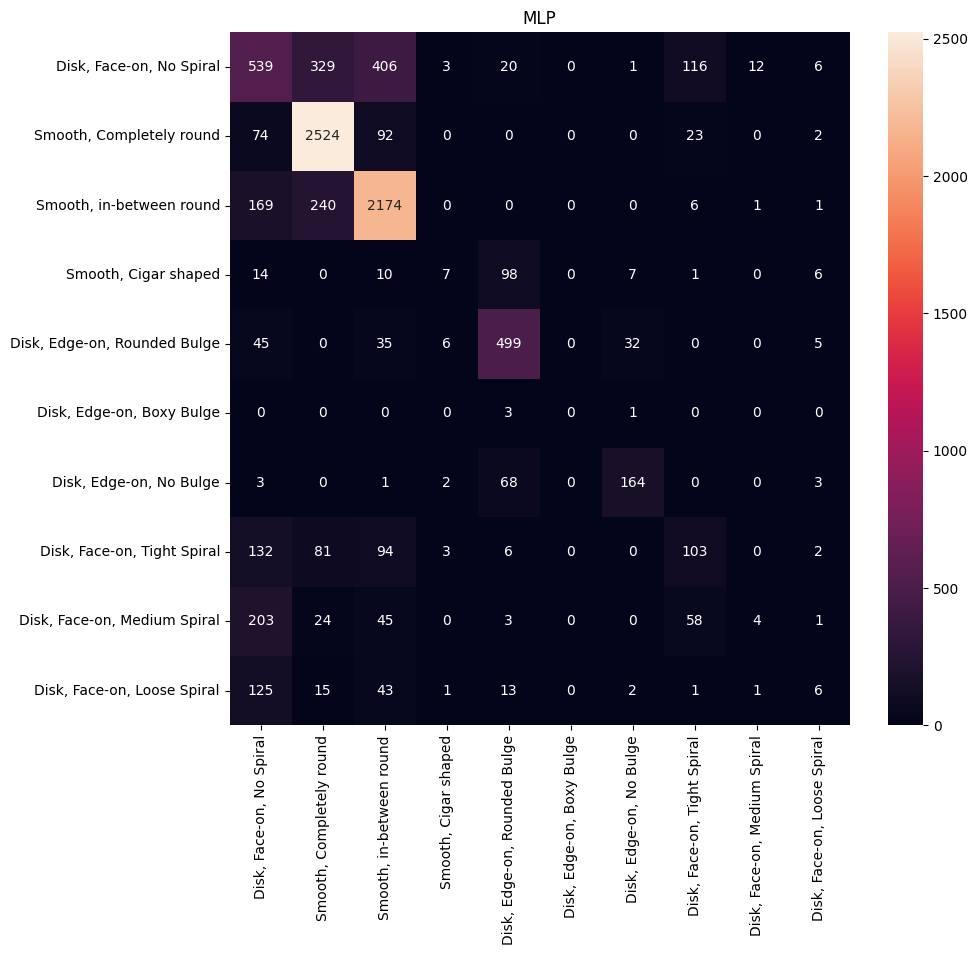

In [16]:
import sklearn

def show_G10_results(y_pred, y_test, title=None):
    cm = sklearn.metrics.confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(10, 9))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names )
    if title is not None:
        plt.title(title)
    plt.show()

show_G10_results(svm.predict(X_test), y_test, title="SVM")
show_G10_results(nn_classifier.predict(X_test), y_test, title="MLP")

### Convolutional Neural Networks

The current state of the art for image classification is the Convolutional Neural Network (CNN). The fundamentals of this architecture were introduced by [Yann Lecun et al. in 1998](http://yann.lecun.com/exdb/lenet/) for written character recognition.

The idea underlying the CNN is that fully connected networks are unefficient for image data since the input vector would be very large (a 69x69x3 image = 14283 input values). A hidden layer with even a moderate amount of neurons would become huge (with 500 neurons, this results in more than 7 million parameters).

Convolutional kernels can shared and used for all pixels in the image. We can perform multiple convolutions on the image to obtain various filtering results. Then, we can apply a non-linear activation (same as in the MLP) and stack a new set of convolutions.

This stack of alternated convolutions and non-linearities forms the basics of CNN.

First, we transpose the image from the HxWxC format (*channels last*) to the CxHxW format (*channels first*). Most deep learning frameworks, such as PyTorch, use the latter.

In [17]:
images_train = images_train.transpose(0, 3, 1, 2)
images_test = images_test.transpose(0, 3, 1, 2)

In [18]:
from torch import nn

cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256, 10)
)

cnn_classifier = skorch.classifier.NeuralNetClassifier(cnn,
                                                       lr=0.005,
                                                       optimizer__momentum=0.9,
                                                       max_epochs=20,
                                                       criterion=nn.CrossEntropyLoss,
                                                       device=device)
cnn_classifier.fit(images_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.7817       0.3572        1.5454  3.5469
      2        1.5270       0.3522        1.4157  2.9713
      3        1.3973       0.4593        1.2718  2.9684
      4        1.2691       0.5212        1.1474  2.9592
      5        1.1681       0.5744        1.0752  2.9633
      6        1.1969       0.5224        1.1534  2.9931
      7        1.0715       0.6161        0.9935  2.9685
      8        0.9780       0.6685        0.8735  2.9708
      9        0.9108       0.6707        0.9192  2.9755
     10        0.8263       0.7082        0.8375  2.9803
     11        0.7836       0.6868        0.9142  2.9731
     12        0.7328       0.7124        0.8368  2.9685
     13        0.6749       0.7449        0.7270  2.9587
     14        0.6496       0.7369        0.7444  2.9636
     15        0.6165       0.7576        0.7210  2.9807
     16        0.5956       0.7

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): ReLU()
    (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): AdaptiveAvgPool2d(output_size=(1, 1))
    (14): Flatten(start_dim=1, end_dim=-1)
 

To test the network, we can do a forward pass on a sample image. For example, let's take image #174 from the test set and move it through the network:

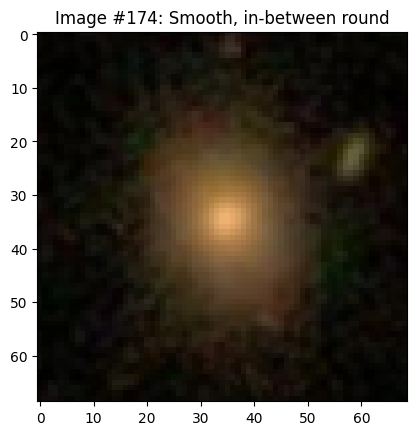

Input image tensor has dimensions torch.Size([1, 3, 69, 69])
The output is a vector of size torch.Size([1, 10])
tensor([[ 4.6019,  8.8310,  8.1774, -3.9363, -1.4250, -5.2432, -7.2197, -0.3873,
         -2.2846, -1.6051]], device='cuda:0')


In [20]:
idx = 174
img = images_test[idx]
label = y_test[idx]

plt.imshow(img.astype('uint8').transpose((1, 2, 0))) and plt.title(f"Image #{idx}: {class_names[label]}") and plt.show()

img_tensor = torch.from_numpy(img).unsqueeze(0) # add 4th dimension along first axis
print(f"Input image tensor has dimensions {img_tensor.size()}")
with torch.no_grad(): # This deactivates the gradient computation (runs faster)
  output = cnn(img_tensor.to(device))
print(f"The output is a vector of size {output.size()}")
print(output)

The output vector has as many values as there are classes. The activation $i$ indicates how much the neuron corresponding to class $i$ has been excited. We can use the argmax operator to get the index of the class predicted by the model. We can get the ranked classes based on their activation :

In [21]:
class_idx = torch.argmax(output[0])
print(f"Predicted class is: {class_idx} ({class_names[class_idx]})")
sorted_classes = np.argsort(-output[0].cpu().numpy()) # argsort by decreasing value
print(f"Other predictions were {[class_names[c] for c in sorted_classes]}")

Predicted class is: 1 (Smooth, Completely round)
Other predictions were ['Smooth, Completely round', 'Smooth, in-between round', 'Disk, Face-on, No Spiral', 'Disk, Face-on, Tight Spiral', 'Disk, Edge-on, Rounded Bulge', 'Disk, Face-on, Loose Spiral', 'Disk, Face-on, Medium Spiral', 'Smooth, Cigar shaped', 'Disk, Edge-on, Boxy Bulge', 'Disk, Edge-on, No Bulge']


Like scikit-learn, `skorch` provides a built-in scoring function so that we don't need to loop over all test samples manually:

In [22]:
accuracy = cnn_classifier.score(images_test, y_test)
print(f"CNN accuracy is {100*accuracy:.2f}%")

CNN accuracy is 76.90%


Using the `predict` method, we can once again get the predictions to build the confusion matrix.

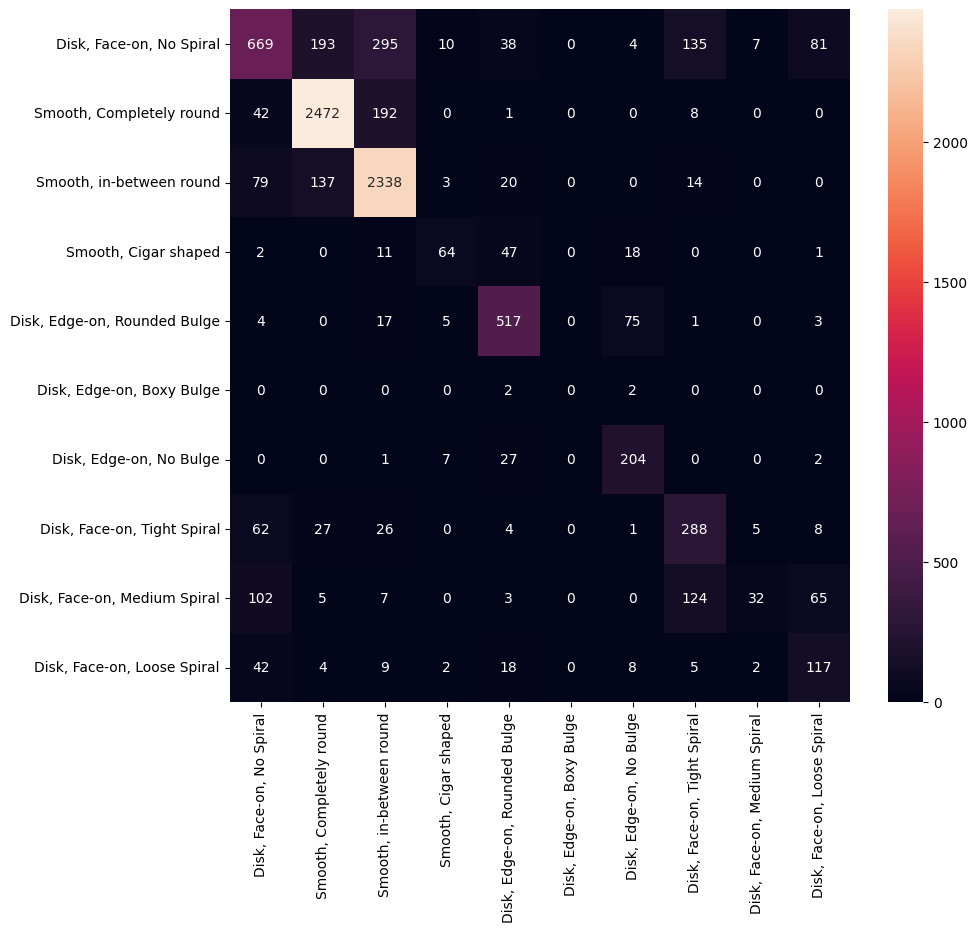

In [23]:
y_pred = cnn_classifier.predict(images_test)
show_G10_results(y_pred, y_test)

Note that the confusion matrix is not to only way to evaluate a classification. Accuracy is not always the best metric, especially when data is unbalanced. We often used precision and recall as additional metrics (also known as precision and sensitivity):

$\text{precision} = \frac{\text{true positives}}{\text{true positives} + \text{true negatives}}$

$\text{recall} = \frac{\text{true positives}}{\text{true positives} + \text{false negatives}}$

These metrics can be consolidated into the $F_1$ score, which is their harmonic mean:
$F_1 = \frac{2 TP}{2TP + FP + FN}$

In [24]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, labels=range(0,10), target_names=class_names, zero_division=0))

                              precision    recall  f1-score   support

    Disk, Face-on, No Spiral       0.67      0.47      0.55      1432
    Smooth, Completely round       0.87      0.91      0.89      2715
    Smooth, in-between round       0.81      0.90      0.85      2591
        Smooth, Cigar shaped       0.70      0.45      0.55       143
Disk, Edge-on, Rounded Bulge       0.76      0.83      0.80       622
   Disk, Edge-on, Boxy Bulge       0.00      0.00      0.00         4
     Disk, Edge-on, No Bulge       0.65      0.85      0.74       241
 Disk, Face-on, Tight Spiral       0.50      0.68      0.58       421
Disk, Face-on, Medium Spiral       0.70      0.09      0.17       338
 Disk, Face-on, Loose Spiral       0.42      0.57      0.48       207

                    accuracy                           0.77      8714
                   macro avg       0.61      0.57      0.56      8714
                weighted avg       0.77      0.77      0.75      8714



### Working with PyTorch

`skorch` is a useful wrapper around PyTorch that is compatible with scikit-learn. However, it does not allow the same fine control on what is going on than working directly with `torch`. Let's look at how to do the same thing but without skorch. This will also help us understand a little bit more what is going on when training the neural network.

We already defined the neural network. We could have used the subclass API to define our own module but, since the CNN we are using is relatively simple, we will keep the Sequential model we defined previously.

To work directly with PyTorch, we need to define a torch-compatible Dataset object. The Dataset details how the data is loaded into memory. Since we already loaded the data in the HDF5 format, we can use the `TensorDataset` tool.

In [25]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(torch.from_numpy(images_train), torch.from_numpy(y_train))
test_ds = TensorDataset(torch.from_numpy(images_test), torch.from_numpy(y_test))

The core functionality of the Datasets is that they are iterable objects that return (sample, label) pairs:

In [26]:
for img, label in train_ds:
    print(f"Image: {img.size()}")
    print(f"Label: {label}")
    break

Image: torch.Size([3, 69, 69])
Label: 2


The gradient descent of deep networks is done in batches. Sampling batches of examples from the dataset is the job of the `DataLoader`:

In [27]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=0)

We can now define a training function that takes a network and a DataLoader and perform the gradient descent training:

In [28]:
def train(network, dataloader, epochs=10, lr=0.01, device=device):
    # Move the network to GPU if required
    network = network.to(device)
    
    # Define the optimization algorithm (here, Stochastic Gradient Descent with momentum)
    optimizer = torch.optim.SGD(network.parameters(), lr=lr, momentum=0.9)
    
    # Define the loss function (in our case, cross-entropy)
    criterion = torch.nn.CrossEntropyLoss()
    
    for e in tqdm(range(epochs), total=epochs): # One epoch = one pass on the whole dataloader
        # This puts the neural network into "training mode"
        network.train()

        # For each batch of examples, do one step of the gradient
        for batch, label in tqdm(dataloader, desc=f"Epoch {e+1}/{epochs}", leave=False):
            # Reset gradient values
            optimizer.zero_grad()
            
            # Move Tensors into CPU or GPU memory
            batch, label = batch.to(device), label.to(device)
            
            # Forward pass (get predictions from the network)
            output = network(batch)
            # Compute the error between predictions and true labels
            loss = criterion(output, label)
            # Compute the gradients (backward pass)
            loss.backward()
            
            # Update the weights (= one step of gradient descent)
            optimizer.step()
    
    return network        

In [29]:
cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256, 10)
)

train(cnn, train_loader, lr=0.005, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/103 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): ReLU()
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): AdaptiveAvgPool2d(output_size=(1, 1))
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=256, out_features=10, bias=True)
)

In [30]:
from sklearn.metrics import accuracy_score

def val(network, dataloader, device=device):
    criterion = torch.nn.CrossEntropyLoss()
    
    network = network.to(device)
    predictions = []
    labels = []
    loss = 0.
    
    with torch.no_grad():
        for batch, label in tqdm(dataloader):
            batch, label = batch.to(device), label.to(device)
            output = network(batch)
            loss += criterion(output, label)
            labels.append(label.cpu().numpy())
            predictions.append(torch.argmax(output, dim=1).cpu().numpy())
            
    print(f"Average loss: {loss/len(labels)}")
    labels, predictions = np.concatenate(labels), np.concatenate(predictions)
    print(f"Accuracy: {accuracy_score(labels, predictions)}")
    return predictions

In [31]:
val(cnn, test_loader)

  0%|          | 0/69 [00:00<?, ?it/s]

Average loss: 1.3368531465530396
Accuracy: 0.8031902685333946


array([1, 1, 0, ..., 2, 1, 4])

**Note :** due to some subtleties in how `skorch` handles the training, this result is not directly comparable to the CNN trained with skorch. Both accuracies should however be in the same ballpark, $\pm$ a few percents.

## Part 3: Bag of tips and tricks

### Data augmentation

Data augmentation is used to produce new training samples from the existing ones. For example, we know that flipping an image of a galaxy does not change the galaxy type -- we say the galaxy classification task is invariant to symetry. Therefore, for a single image, we know that its flipped and mirrored versions are acceptable images of the same class:

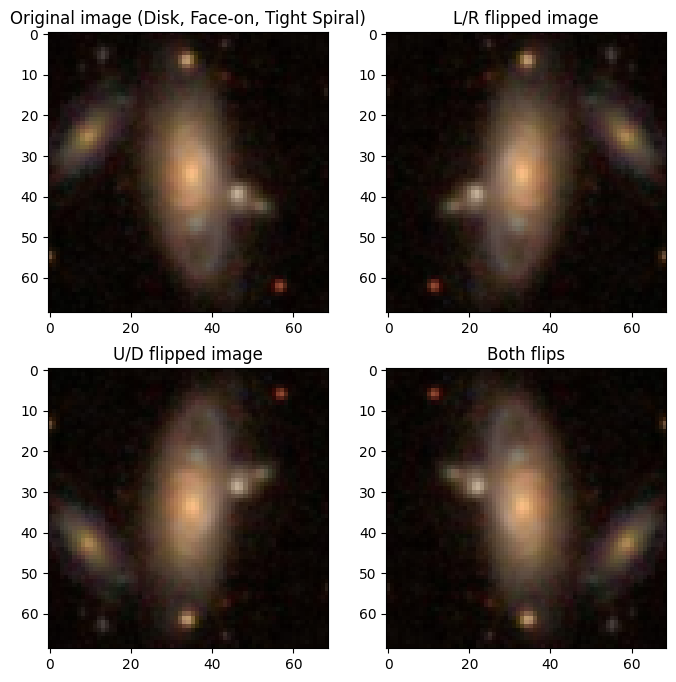

In [32]:
fig = plt.figure(figsize=(8,8))
img, l = images[9], class_names[labels[9]]
fig.add_subplot(221)
plt.imshow(img)
plt.title(f"Original image ({l})")
mirror = np.fliplr(img)
fig.add_subplot(222)
plt.imshow(mirror)
plt.title("L/R flipped image")
flip = np.flipud(img)
fig.add_subplot(223)
plt.imshow(flip)
plt.title("U/D flipped image")
both = np.fliplr(flip)
fig.add_subplot(224)
plt.imshow(both)
plt.title("Both flips")
plt.show()

To achieve on-the-fly data augmentation, we need to define a custom `Dataset` in PyTorch. Fortunately for us, this is not too hard: we mostly need to define an iterator subclassing `Dataset` that supports the `__getitem__()` method. See the code below:

In [33]:
from torch.utils.data import Dataset

class Galaxy10Dataset(Dataset):
    def __init__(self, data, targets, transform=None):
        super(Galaxy10Dataset, self).__init__()
        
        assert(len(data) == len(targets))
        self.data = data.astype('uint8')
        self.targets = targets
        self.transform = transform
    
    def __getitem__(self, index):
        
        img, target = self.data[index], self.targets[index]
        
        if self.transform is not None:
            img = 255 * self.transform(img)
        return img, target

    def __len__(self):
        return len(self.data)

Everytime we will query the dataset object for an image, it will apply the `transform` function on it.

`torchvision` provides some common image transformations that we can reuse. Our overall transformation is composed of four steps:
1. We convert the image array to PIL format for easier manipulation,
2. Horizontal flip the image with probability p=0.5,
3. Vertical flip the image with probability p=0.5,
4. Extract a random 64x64 crop from the image (simulate random translations),
5. Convert PIL image back to Tensor.

In [34]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomCrop((64, 64)),
    transforms.ToTensor()
])

As an example, we can manually apply the `transform` object in a sample image to test its effect. Repeat this cell several time to see the image on the right change depending on the random transformations.

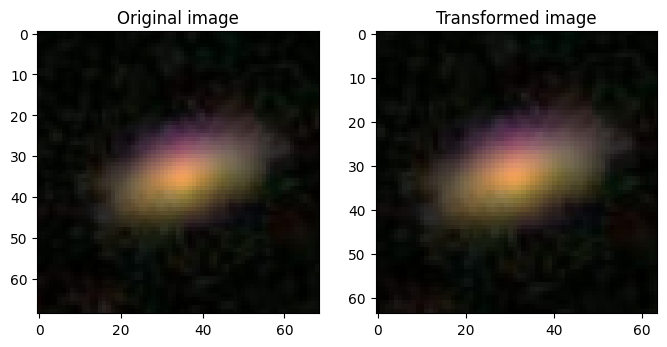

In [35]:
image = images_train[0].astype('uint8').transpose((1, 2, 0))
transformed_image = transform(image)
fig = plt.figure(figsize=(8,8))
fig.add_subplot(121)
plt.title("Original image")
plt.imshow(image)
fig.add_subplot(122)
plt.title("Transformed image")
plt.imshow(transformed_image.numpy().transpose((1, 2, 0))) and plt.show()

Now, we can finally build a training dataset and the corresponding `DataLoader` that will use the training images and randomly apply data augmentation to them.

In [36]:
train_augmented_ds = Galaxy10Dataset(images_train.transpose((0, 2, 3, 1)), y_train, transform=transform)

train_augmented_loader = DataLoader(train_ds, batch_size=128, shuffle=True, num_workers=0)

By including new images corresponding to both mirroring and flipping, we virtually multiply by 3 the size of the training set. This often results in better generalization and higher accuracy.

In [37]:
cnn = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(128, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.MaxPool2d(kernel_size=(2, 2)),
    nn.ReLU(),
    nn.Conv2d(256, 256, kernel_size=(3,3), padding=1),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256, 10)
)

train(cnn, train_augmented_loader, lr=0.005, epochs=50)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 2/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 3/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 4/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 5/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 6/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 7/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 8/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 9/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 10/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 11/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 12/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 13/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 14/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 15/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 16/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 17/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 18/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 19/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 20/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 21/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 22/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 23/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 24/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 25/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 26/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 27/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 28/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 29/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 30/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 31/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 32/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 33/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 34/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 35/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 36/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 37/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 38/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 39/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 40/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 41/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 42/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 43/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 44/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 45/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 46/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 47/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 48/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 49/50:   0%|          | 0/103 [00:00<?, ?it/s]

Epoch 50/50:   0%|          | 0/103 [00:00<?, ?it/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (8): ReLU()
  (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (11): ReLU()
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): AdaptiveAvgPool2d(output_size=(1, 1))
  (14): Flatten(start_dim=1, end_dim=-1)
  (15): Linear(in_features=256, out_features=10, bias=True)
)

In [38]:
y_pred = val(cnn, test_loader)

  0%|          | 0/69 [00:00<?, ?it/s]

Average loss: 1.134819746017456
Accuracy: 0.7975671333486344


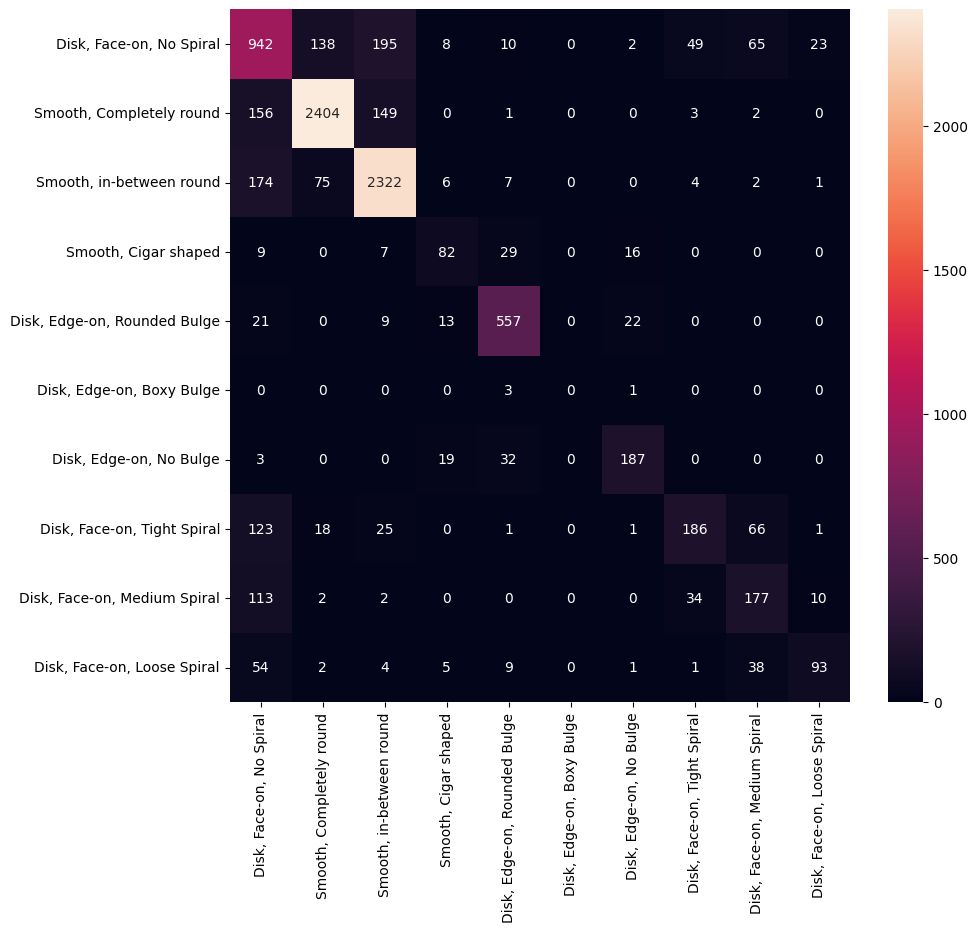

In [39]:
show_G10_results(y_pred, y_test)

**Takeaway 5**: more data always beat a clever algorithm. When you can, use data augmentation to increase the size of your dataset.